In [0]:
%%capture
# Install libraries
!pip install cplex
!apt install coinor-libipopt-dev
!pip install ipopt

In [0]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import cplex
import ipopt
import copy

# Strategy 1 - Buy and Hold Portfolio

In [0]:
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
   x_optimal = x_init
   cash_optimal = cash_init
   return x_optimal, cash_optimal

# Strategy 2 -Equally Weighted Portfolio

In [0]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices): 
  amount = np.dot(cur_prices,x_init) + cash_init

  # Equal Weighting scheme
  w_equal = 1/20

  portfolio_weights_equal_weight.append([1/20]* 20)

  # Find amount invested in each asset, number of shares and optimal cash on hand
  equal_weighted = np.ones(20) * amount * w_equal
  x_optimal = np.floor(equal_weighted/cur_prices)
  transaction = cur_prices * (x_optimal - x_init) * 0.005
  cash_optimal = amount - np.dot(cur_prices,x_optimal) - np.sum(transaction)
  
  # Provisions for re-balancing the porfolio
  x_rebalance = np.zeros(20)
  min_asset = min(cur_prices)

# Check if cash is positive
  if cash_optimal > 0:
    for label in range(0,len(x_rebalance)):
      if cur_prices[label] == min_asset:      # Find the minimum asset price    
       new_asset = np.floor(cash_optimal/(min_asset*1.005))   # Number of assets to be bought from cash-on hand subjected to transaction costs
       x_rebalance[label] = new_asset
       x_optimal += x_rebalance     # Rebalance the portfolio and add newly bought assets 

# Check if cash is negative
  if cash_optimal < 0:
    for label in range(0,len(x_rebalance)): # Find the minimum asset price
       if cur_prices[label] == min_asset:
        new_asset = np.floor(cash_optimal/(min_asset*1.005)) # Number of assets minimum assets to be removed 
        x_rebalance[label] = new_asset
        x_optimal += x_rebalance  # Rebalance the portfolio

# Check whether we can buy the new portfolio subject to transaction costs
  transaction = cur_prices * (x_optimal - x_init) * 0.005
  
# Find the optimal cash after rebalancing the portfolio
  cash_optimal = amount - np.dot(cur_prices,x_optimal) - np.sum(transaction)

  return x_optimal, cash_optimal

# Strategy 3 -Mean Variance Portfolio

In [0]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
  cpx = cplex.Cplex()
  cpx.objective.set_sense(cpx.objective.sense.minimize)
  amount = np.dot(cur_prices,x_init) + cash_init
  n = 20
  # Lower bound
  lower = [0.0] * n
  # Upper bound
  upper = [1.0] * n

# Linear part of the objective (empty)
  c = [0.0] * n

  # Linear constraints in Ax = b format
  A = []
  for k in range(n):
    A.append([[0],[1]]) # Sparse A matrix
# RHS (b) of the linear constraints
  b = [1.0]
  # Asset names 
  var_names = ["w_%s" % i for i in range(1,n+1)]

  # Construct Optimization problem
  cpx.linear_constraints.add(rhs=b, senses="E")
  cpx.variables.add(obj = c, lb=lower, ub=upper, columns=A, names=var_names)
  # Find Q matrix and convert into sparse format

  Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)] 
  cpx.objective.set_quadratic(Qmat)

  # Disable CPLEX output to screen

  cpx.set_results_stream(None)
  cpx.set_warning_stream(None)
  alg = cpx.parameters.lpmethod.values
  cpx.parameters.qpmethod.set(alg.concurrent)
  cpx.solve()
  
  w_minvar = cpx.solution.get_values() # Porfolio weights

  portfolio_weights_min_var.append(w_minvar)   # Get a list of porfolio wei

  amount = np.dot(cur_prices,x_init) + cash_init

# Find amount invested in each asset, number of shares and optimal cash on hand

  min_variance = np.ones(20) * amount * w_minvar
  x_optimal = np.floor(min_variance/cur_prices)
  transaction = cur_prices * (x_optimal - x_init) * 0.005
  cash_optimal = amount - np.dot(cur_prices,x_optimal) - np.sum(transaction)

# Provisions for re-balancing the porfolio

  x_rebalance = np.zeros(20)
  min_asset = min(cur_prices)

# Check if cash is positive
  if cash_optimal > 0:
    for label in range(0,len(x_rebalance)):
      if cur_prices[label] == min_asset:    # Find the minimum asset price
        new_asset = np.floor(cash_optimal/(min_asset*1.005))     # Number of assets to be bought from cash-on hand subjected to transaction costs
        x_rebalance[label] = new_asset
        x_optimal += x_rebalance      # Rebalance the portfolio and add newly bought assets

# Check if cash is negative
  if cash_optimal < 0:
    for label in range(0,len(x_rebalance)):       
      if cur_prices[label] == min_asset:      # Find the minimum asset price
        new_asset = np.floor(cash_optimal/(min_asset*1.005))   # Number of assets minimum assets to be removed 
        x_rebalance[label] = new_asset
        x_optimal += x_rebalance      # Rebalance the portfolio 

# Check whether we can buy the new portfolio subject to transaction costs
  transaction = cur_prices * (x_optimal - x_init) * 0.005

# Find the optimal cash after rebalancing the portfolio
  cash_optimal = amount - np.dot(cur_prices,x_optimal) - np.sum(transaction) 

  return x_optimal, cash_optimal

# Strategy 4 - Max Sharpe Ratio Portfolio

In [0]:
def strat_max_sharpe(x_init, cash_init, mu, Q, cur_prices):

  cpx = cplex.Cplex()
  cpx.objective.set_sense(cpx.objective.sense.minimize)

  n = 21
  # Lower bound
  lower = [0.0] * n
  # Upper bound
  upper = [cplex.infinity] * n

  #Linear part of objective (empty)
  c = [0.0] * n

#Risk Free Rate (for each trading day)
  r_rf = 0.025/252

# Difference mu - r_rf
  term1 = np.ndarray.tolist(mu-r_rf) 
  term1.append(0)

# Linear constraints 
  A = []
  for k in range(n-1):
    A.append([[0,1],[term1[k],1]])
  A.append([[0,1],[0,-1]])      # Make arrangments for kappa
  
# RHS of linear constraints
  b = [1.0, 0.0]  

# Names of porfolio weights
  var_names = ["w_%s" % i for i in range(1,n+1)]

# Prepare the objective
  cpx.linear_constraints.add(rhs=b, senses="EE")
  cpx.variables.add(obj = c, lb=lower, ub=upper, columns=A, names=var_names)

# Find Q_tilda by adding an empty row and column 
  Q_tilda = np.append(Q,np.zeros((20,1)),axis= 1)
  Q_tilda = np.append(Q_tilda,np.zeros((1,21)),axis = 0)

# Convert to list of solver
  Qmat_tilda = [[list(range(n)), list(2*Q_tilda[k,:])] for k in range(n)]

  cpx.objective.set_quadratic(Qmat_tilda)   #Set quadratic objective

# Hide Cplex results
  cpx.set_results_stream(None)
  cpx.set_warning_stream(None)
  alg = cpx.parameters.lpmethod.values
  cpx.parameters.qpmethod.set(alg.concurrent)
  cpx.solve()
  
  results = cpx.solution.get_values() 
  kappa = results[-1] # Get kappa term

  # Compute porfolio weightes w = x/k
  w_maxsharpe = results[:-1]
  w_maxsharpe = [number / kappa for number in w_maxsharpe]

  portfolio_weights_max_sharpe.append(w_maxsharpe) # Create a list of porfolio weights

  amount = np.dot(cur_prices,x_init) + cash_init

# Find amount invested in each asset, number of shares and optimal cash on hand
  max_sharpe = np.ones(20) * amount * w_maxsharpe
  x_optimal = np.floor(max_sharpe/cur_prices)
  transaction = cur_prices * (x_optimal - x_init) * 0.005
  cash_optimal = amount - np.dot(cur_prices,x_optimal) - np.sum(transaction)

# Provisions for re-balancing the porfolio
  x_rebalance = np.zeros(20)
  min_asset = min(cur_prices)

# Check if cash is positive
  if cash_optimal > 0:
    for label in range(0,len(x_rebalance)):
      if cur_prices[label] == min_asset:    # Find the minimum asset price
        new_asset = np.floor(cash_optimal/(min_asset*1.005))    # Number of assets to be bought from cash-on hand subjected to transaction costs
        x_rebalance[label] = new_asset
        x_optimal += x_rebalance    # Rebalance the portfolio and add newly bought assets

# Check if cash is negative
  if cash_optimal < 0:
    for label in range(0,len(x_rebalance)):
      if cur_prices[label] == min_asset:  # Find the minimum asset price
        new_asset = np.floor(cash_optimal/(min_asset*1.005))   # Number of assets minimum assets to be removed
        x_rebalance[label] = new_asset
        x_optimal += x_rebalance      # Rebalance the portfolio

# Check whether we can buy the new portfolio subject to transaction costs
  transaction = cur_prices * (x_optimal - x_init) * 0.005

# Find the optimal cash after rebalancing the portfolio
  cash_optimal = amount - np.dot(cur_prices,x_optimal) - np.sum(transaction) 

  return x_optimal, cash_optimal

# Strategy 5 - Equal Risk Contribution Portfolio

In [0]:
def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):

  n = 20
  w_equalrc = [1.0/n] * n

  class lerc(object):
      def __init__(self):
          pass

      def objective(self, x_init):
      # The callback for calculating the objective
          y = x_init * np.dot(Q, x_init)
          fval = 0
          for i in range(n):
            for j in range(i,n):
                xij = y[i] - y[j]
                fval = fval + xij*xij
          fval = 2*fval
          return fval

      def gradient(self, x_init):
        # The callback for calculating the gradient
        # Insert your gradient computations here
          grad = np.zeros(n)
          y = x_init * np.dot(Q, x_init)
          for i in range(0,n):
            for j in range(i,n):
              dyi = np.sum(Q[i,:] * x_init) + np.sum(Q[i,i] * x_init[i])
              dyj = Q[i,j] * x_init[i]
              gradij  = (y[i] - y[j]) * (dyi - dyj)  
          #print(y[i],y[j],dyi,dyj,g)
              grad[i] += gradij
          grad = 4 * grad
        # You can use finite differences to check the gradient
          return grad

      def constraints(self, x_init):
        # The callback for calculating the constraints
          return [1.0] * n

      def jacobian(self, x_init):
        # The callback for calculating the Jacobian
          return np.array([[1.0] * n])

      # def intermediate(
      #       self,
      #       alg_mod,
      #       iter_count,
      #       obj_value,
      #       inf_pr,
      #       inf_du,
      #       mu,
      #       d_norm,
      #       regularization_size,
      #       alpha_du,
      #       alpha_pr,
      #       ls_trials
      #       ):
        # Example for the use of the intermediate callback.
        #print("Objective value at iteration #%d is - %g" % (iter_count, obj_value))

  lb = [0.0] * n  # lower bounds on variables
  ub = [1.0] * n  # upper bounds on variables
  cl = [1]        # lower bounds on constraints
  cu = [1]        # upper bounds on constraints

  # Define IPOPT problem
  nlp = ipopt.problem(n=len(w_equalrc), m=len(cl), problem_obj=lerc(), lb=lb, ub=ub, cl=cl, cu=cu)

  # Set the IPOPT options
  nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
  nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
  nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
  nlp.addOption('tol'.encode('utf-8'), 1e-10)

  # Solve the problem
  w_erc,info = nlp.solve(w_equalrc)

  # var_ERC = np.dot(w_erc, np.dot(Q, w_erc))
  # std_ERC = np.sqrt(var_ERC)
  # RC_ERC = (w_erc * np.dot(Q, w_erc)) / std_ERC

  portfolio_weights_equal_risk.append(w_erc)     # Get a list of porfolio wei

  amount = np.dot(cur_prices,x_init) + cash_init

# Find amount invested in each asset, number of shares and optimal cash on hand
  equal_risk = np.ones(20) * amount * w_erc
  x_optimal = np.floor(equal_risk/cur_prices)
  transaction = cur_prices * (x_optimal - x_init) * 0.005
  cash_optimal = amount - np.dot(cur_prices,x_optimal) - np.sum(transaction)

# Provisions for re-balancing the porfolio
  x_rebalance = np.zeros(20)
  min_asset = min(cur_prices)

# Check if cash is positive
  if cash_optimal > 0:
    for label in range(0,len(x_rebalance)):
      if cur_prices[label] == min_asset:    # Find the minimum asset price
        new_asset = np.floor(cash_optimal/(min_asset*1.005))    # Number of assets to be bought from cash-on hand subjected to transaction costs
        x_rebalance[label] = new_asset
        x_optimal += x_rebalance    # Rebalance the portfolio and add newly bought assets

# Check if cash is negative
  if cash_optimal < 0:
    for label in range(0,len(x_rebalance)):
      if cur_prices[label] == min_asset:  # Find the minimum asset price
        new_asset = np.floor(cash_optimal/(min_asset*1.005))   # Number of assets minimum assets to be removed
        x_rebalance[label] = new_asset
        x_optimal += x_rebalance      # Rebalance the portfolio

# Check whether we can buy the new portfolio subject to transaction costs
  transaction = cur_prices * (x_optimal - x_init) * 0.005

# Find the optimal cash after rebalancing the portfolio
  cash_optimal = amount - np.dot(cur_prices,x_optimal) - np.sum(transaction) 

  return x_optimal, cash_optimal

# Strategy 6 - Leveraged Equal Risk Contribution Portfolio

In [0]:
def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):

  n = 20
  w_equalrc = [1.0/n] * n

  class erc(object):
      def __init__(self):
          pass

      def objective(self, x_init):
      # The callback for calculating the objective
          y = x_init * np.dot(Q, x_init)
          fval = 0
          for i in range(n):
            for j in range(i,n):
                xij = y[i] - y[j]
                fval = fval + xij*xij
          fval = 2*fval
          return fval

      def gradient(self, x_init):
        # The callback for calculating the gradient
        # Insert your gradient computations here
          grad = np.zeros(n)
          y = x_init * np.dot(Q, x_init)
          for i in range(0,n):
            for j in range(i,n):
              dyi = np.sum(Q[i,:] * x_init) + np.sum(Q[i,i] * x_init[i])
              dyj = Q[i,j] * x_init[i]
              gradij  = (y[i] - y[j]) * (dyi - dyj)  
          #print(y[i],y[j],dyi,dyj,g)
              grad[i] += gradij
          grad = 4 * grad
        # You can use finite differences to check the gradient
          return grad

      def constraints(self, x_init):
        # The callback for calculating the constraints
          return [1.0] * n

      def jacobian(self, x_init):
        # The callback for calculating the Jacobian
          return np.array([[1.0] * n])

      # def intermediate(
      #       self,
      #       alg_mod,
      #       iter_count,
      #       obj_value,
      #       inf_pr,
      #       inf_du,
      #       mu,
      #       d_norm,
      #       regularization_size,
      #       alpha_du,
      #       alpha_pr,
      #       ls_trials
      #       ):
        # Example for the use of the intermediate callback.
        #print("Objective value at iteration #%d is - %g" % (iter_count, obj_value))

  lb = [0.0] * n  # lower bounds on variables
  ub = [1.0] * n  # upper bounds on variables
  cl = [1]        # lower bounds on constraints
  cu = [1]        # upper bounds on constraints

  # Define IPOPT problem
  nlp = ipopt.problem(n=len(w_equalrc), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)

  # Set the IPOPT options
  nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
  nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
  nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
  nlp.addOption('tol'.encode('utf-8'), 1e-10)

  # Solve the problem
  w_lerc,info = nlp.solve(w_equalrc)

  var_ERC = np.dot(w_lerc, np.dot(Q, w_lerc))
  std_ERC = np.sqrt(var_ERC)
  RC_ERC = (w_lerc * np.dot(Q, w_lerc)) / std_ERC

  amount = np.dot(cur_prices,x_init) + cash_init
  borrow_amount = np.dot(data_prices[0,:], init_positions)

  if period == 1:
    amount = amount + borrow_amount
  else:
    amount = amount

  # r_rf = 0.025
  interest = r_rf/6 * borrow_amount

  portfolio_weights_lever_equal_risk.append(w_lerc)    # Get a list of porfolio wei
  
# Find amount invested in each asset, number of shares and optimal cash on hand
  equal_risk = np.ones(20) * amount * w_lerc
  x_optimal = np.floor(equal_risk/cur_prices)
  transaction = cur_prices * (x_optimal - x_init) * 0.005

  if period == 1:
    cash_optimal = amount - np.dot(cur_prices,x_optimal) - np.sum(transaction) - interest - borrow_amount
  else:
    cash_optimal = amount - np.dot(cur_prices,x_optimal) - np.sum(transaction) - interest

# Provisions for re-balancing the porfolio
  x_rebalance = np.zeros(20)
  min_asset = min(cur_prices)

# Check if cash is positive
  if cash_optimal > 0:
    for label in range(0,len(x_rebalance)):
      if cur_prices[label] == min_asset:    # Find the minimum asset price
        new_asset = np.floor(cash_optimal/(min_asset*1.005))    # Number of assets to be bought from cash-on hand subjected to transaction costs
        x_rebalance[label] = new_asset
        x_optimal += x_rebalance    # Rebalance the portfolio and add newly bought assets

# Check if cash is negative
  if cash_optimal < 0:
    for label in range(0,len(x_rebalance)):
      if cur_prices[label] == min_asset:  # Find the minimum asset price
        new_asset = np.floor(cash_optimal/(min_asset*1.005))   # Number of assets minimum assets to be removed
        x_rebalance[label] = new_asset
        x_optimal += x_rebalance      # Rebalance the portfolio

# Check whether we can buy the new portfolio subject to transaction costs
  transaction = cur_prices * (x_optimal - x_init) * 0.005

# Find the optimal cash after rebalancing the portfolio
  if period ==1:
    cash_optimal = amount - np.dot(cur_prices,x_optimal) - np.sum(transaction) - interest - borrow_amount
  else:
    cash_optimal = amount - np.dot(cur_prices,x_optimal) - np.sum(transaction) - interest

  return x_optimal, cash_optimal

# Strategy 7 - Robust Mean Variance Optimization Portfolio

In [0]:
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):

  ############## MAX SHARPE ################
  cpx = cplex.Cplex()
  cpx.objective.set_sense(cpx.objective.sense.minimize)

  n = 21
  # Lower bound
  lower = [0.0] * n
  # Upper bound
  upper = [cplex.infinity] * n

  #Linear part of objective (empty)
  c = [0.0] * n

#Risk Free Rate (for each trading day)
  r_rf = 0.025/252

# Difference mu - r_rf
  term1 = np.ndarray.tolist(mu-r_rf) 
  term1.append(0)

# Linear constraints 
  A = []
  for k in range(n-1):
    A.append([[0,1],[term1[k],1]])
  A.append([[0,1],[0,-1]])      # Make arrangments for kappa
  
# RHS of linear constraints
  b = [1.0, 0.0]  

# Names of porfolio weights
  var_names = ["w_%s" % i for i in range(1,n+1)]

# Prepare the objective
  cpx.linear_constraints.add(rhs=b, senses="EE")
  cpx.variables.add(obj = c, lb=lower, ub=upper, columns=A, names=var_names)

# Find Q_tilda by adding an empty row and column 
  Q_tilda = np.append(Q,np.zeros((20,1)),axis= 1)
  Q_tilda = np.append(Q_tilda,np.zeros((1,21)),axis = 0)

# Convert to list of solver
  Qmat_tilda = [[list(range(n)), list(2*Q_tilda[k,:])] for k in range(n)]

  cpx.objective.set_quadratic(Qmat_tilda)   #Set quadratic objective

# Hide Cplex results
  cpx.set_results_stream(None)
  cpx.set_warning_stream(None)
  alg = cpx.parameters.lpmethod.values
  cpx.parameters.qpmethod.set(alg.concurrent)
  cpx.solve()
  
  results = cpx.solution.get_values() 
  kappa = results[-1] # Get kappa term

  # Compute porfolio weightes w = x/k
  w_maxsharpe = results[:-1]
  w_maxsharpe = [number / kappa for number in w_maxsharpe]

  ################ MIN VAR ########################

  cpx = cplex.Cplex()
  cpx.objective.set_sense(cpx.objective.sense.minimize)
  amount = np.dot(cur_prices,curr_positions) + curr_cash
  n = 20
  w_equalrc = [1.0/n] * n
  # Lower bound
  lower = [0.0] * n
  # Upper bound
  upper = [1.0] * n

# Linear part of the objective (empty)
  c = [0.0] * n

  # Linear constraints in Ax = b format
  A = []
  for k in range(n):
    A.append([[0],[1]]) # Sparse A matrix
# RHS (b) of the linear constraints
  b = [1.0]
  # Asset names 
  var_names = ["w_%s" % i for i in range(1,n+1)]

  # Construct Optimization problem
  cpx.linear_constraints.add(rhs=b, senses="E")
  cpx.variables.add(obj = c, lb=lower, ub=upper, columns=A, names=var_names)
  # Find Q matrix and convert into sparse format

  Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)] 
  cpx.objective.set_quadratic(Qmat)

  # Disable CPLEX output to screen

  cpx.set_results_stream(None)
  cpx.set_warning_stream(None)
  alg = cpx.parameters.lpmethod.values
  cpx.parameters.qpmethod.set(alg.concurrent)
  cpx.solve()
  
  w_minvar = cpx.solution.get_values() # Porfolio weights
  
  ################ ROBUST OPTIMIZAION ##################

  ret_minvar = np.dot(mu, w_maxsharpe)  ### CHANGE VALUES  
  Portf_Retn = ret_minvar     

  var_matr = np.diag(np.diag(Q))
  rob_init = np.dot(w_equalrc, np.dot(var_matr, w_equalrc)) # return estimation error of initial portfolio
  rob_bnd  = rob_init # target return estimation error

  cpx = cplex.Cplex()
  cpx.objective.set_sense(cpx.objective.sense.minimize)

  A = []
  for k in range(n):
    A.append([[0,1],[1.0,mu[k]]])

  cpx.linear_constraints.add(rhs=[1.0,Portf_Retn], senses="EG")

  cpx.variables.add(obj=c, lb=lower, ub=upper, columns=A, names=var_names)

  Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]

  cpx.objective.set_quadratic(Qmat)

  Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(n), val=np.diag(var_matr))
  cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")
  
  # Disable CPLEX output to screen

  cpx.set_results_stream(None)
  cpx.set_warning_stream(None)
  alg = cpx.parameters.lpmethod.values
  cpx.parameters.qpmethod.set(alg.concurrent)
  cpx.solve()

  w_robust= cpx.solution.get_values()

  w_r = np.array(w_robust)
  w_r_nonrnd = copy.deepcopy(w_r)
  w_r[w_r<1e-6] = 0
  w_r = w_r / np.sum(w_r)
  w_robust = np.ndarray.tolist(w_r) 

  portfolio_weights_robust.append(w_robust)     # Get a list of porfolio wei

  amount = np.dot(cur_prices,x_init) + cash_init

# Find amount invested in each asset, number of shares and optimal cash on hand
  equal_risk = np.ones(20) * amount * w_robust
  x_optimal = np.floor(equal_risk/cur_prices)
  transaction = cur_prices * (x_optimal - x_init) * 0.005
  cash_optimal = amount - np.dot(cur_prices,x_optimal) - np.sum(transaction)

# Provisions for re-balancing the porfolio
  x_rebalance = np.zeros(20)
  min_asset = min(cur_prices)

# Check if cash is positive
  if cash_optimal > 0:
    for label in range(0,len(x_rebalance)):
      if cur_prices[label] == min_asset:    # Find the minimum asset price
        new_asset = np.floor(cash_optimal/(min_asset*1.005))    # Number of assets to be bought from cash-on hand subjected to transaction costs
        x_rebalance[label] = new_asset
        x_optimal += x_rebalance    # Rebalance the portfolio and add newly bought assets

# Check if cash is negative
  if cash_optimal < 0:
    for label in range(0,len(x_rebalance)):
      if cur_prices[label] == min_asset:  # Find the minimum asset price
        new_asset = np.floor(cash_optimal/(min_asset*1.005))   # Number of assets minimum assets to be removed
        x_rebalance[label] = new_asset
        x_optimal += x_rebalance      # Rebalance the portfolio

# Check whether we can buy the new portfolio subject to transaction costs
  transaction = cur_prices * (x_optimal - x_init) * 0.005

# Find the optimal cash after rebalancing the portfolio
  cash_optimal = amount - np.dot(cur_prices,x_optimal) - np.sum(transaction) 


  return x_optimal, cash_optimal

In [0]:
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
  temp = [int(x) for x in datestr.split('/')]
  return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2014 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2014)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2014
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']

#N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_sharpe,strat_equal_risk_contr, strat_lever_equal_risk_contr,strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)

# Determine variable to capture values
daily_values_buy_and_hold = []
period_values_buy_and_hold = []

daily_value_equal_weighted = []
portfolio_weights_equal_weight = []
cash_equal_weight = []
period_values_equal_weighted= []

daily_values_min_var = []
portfolio_weights_min_var = []
cash_min_var = []
period_values_min_var = []

daily_values_max_sharpe = []
portfolio_weights_max_sharpe = []
cash_max_sharpe = []
period_values_max_sharpe = []

daily_values_equal_risk = []
portfolio_weights_equal_risk = []
cash_equal_risk = []
period_values_equal_risk = []

daily_values_lever_equal_risk = []
portfolio_weights_lever_equal_risk = []
cash_lever_equal_risk = []
period_values_lever_equal_risk = []

daily_values_robust = []
portfolio_weights_robust = []
cash_robust = []
period_values_robust = []

valueend = []


Initial portfolio value = $ 1000002.12



In [0]:
for period in range(1, N_periods+1):

   # Compute current year and month, first and last day of the period
  if dates_array[0, 0] == 15:
      cur_year  = 15 + math.floor(period/7)
  else:
      cur_year  = 2015 + math.floor(period/7)

  cur_month = 2*((period-1)%6) + 1
  day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
  day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
  print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))

   # Prices for the current day
  cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
  for strategy  in range(N_strat):
    # Get current portfolio positions
    if period == 1:
      curr_positions = init_positions
      curr_cash = 0
      portf_value[strategy] = np.zeros((N_days, 1))
    else:
      curr_positions = x[strategy, period-2]
      curr_cash = cash[strategy, period-2]

      # Compute strategy
    x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################


              ############# VALIDATION AND TESTING DONE WITHIN THE FUNCTION ###########################


    p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]

      # Compute portfolio value
    #p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
    portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
    print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}, cash on-hand = $ {3:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0], cash[strategy, period-1]))


                                            ############ CAPTURE VALUES  ###############
    p_values_list = np.ndarray.tolist(p_values)
  
    if strategy == 0:         
      daily_values_buy_and_hold.append(p_values_list)    # Append portfolio values for the given day
      period_values_buy_and_hold.append([portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]])
    daily_values_buy_and_hold_flat = [val for sublist in daily_values_buy_and_hold for val in sublist]    # flatten over all period to daily values
      
    if strategy == 1:
      daily_value_equal_weighted.append(p_values_list)    # Append portfolio values for the given day
      cash_equal_weight.append(cash[strategy, period-1]) # Get the cash value
      period_values_equal_weighted.append([portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]])
    daily_values_equal_weighted_flat = [val for sublist in daily_value_equal_weighted for val in sublist]   # flatten over all period to daily values
                                      
    if strategy == 2:
      daily_values_min_var.append(p_values_list)    # Append portfolio values for the given day
      cash_min_var.append(cash[strategy, period-1])   # Get the cash value
      period_values_min_var.append([portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]])
    daily_values_min_var_flat = [val for sublist in daily_values_min_var for val in sublist]     # flatten over all period to daily values    
      
    if strategy == 3:
      daily_values_max_sharpe.append(p_values_list)   # Append portfolio values for the given day
      cash_max_sharpe.append(cash[strategy, period-1])    # Get the cash value
      period_values_max_sharpe.append([portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]])
    daily_values_max_sharpe_flat = [val for sublist in daily_values_max_sharpe for val in sublist]    # flatten over all period to daily values

    if strategy == 4:
      daily_values_equal_risk.append(p_values_list)   # Append portfolio values for the given day
      cash_equal_risk.append(cash[strategy, period-1]) # Get the cash value
      period_values_equal_risk.append([portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]])
    daily_values_equal_risk_flat = [val for sublist in daily_values_equal_risk for val in sublist]    # flatten over all period to daily values
    
    if strategy == 5:
      daily_values_lever_equal_risk.append(p_values_list)   # Append portfolio values for the given day
      cash_lever_equal_risk.append(cash[strategy, period-1]) # Get the cash value
      period_values_lever_equal_risk.append([portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]])
    daily_values_lever_equal_risk_flat = [val for sublist in daily_values_lever_equal_risk for val in sublist]    # flatten over all period to daily values    peroid_values_min_var = [portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]]

    if strategy == 6:
      daily_values_robust.append(p_values_list)   # Append portfolio values for the given day
      cash_robust.append(cash[strategy, period-1]) # Get the cash value
      period_values_robust.append([portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]])
    daily_values_robust_flat = [val for sublist in daily_values_robust for val in sublist]    # flatten over all period to daily values

    if period ==12:

      valueend.append(portf_value[strategy][day_ind_end][0])

   # Compute expected returns and covariances for the next period
  cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
  mu = np.mean(cur_returns, axis = 0)
  Q = np.cov(cur_returns.T)


Period 1: start date 1/2/2015, end date 2/27/2015
  Strategy "Buy and Hold", value begin = $ 1000002.12, value end = $ 1043785.08, cash on-hand = $ 0.00
  Strategy "Equally Weighted Portfolio", value begin = $ 1000002.13, value end = $ 1027870.30, cash on-hand = $ 1.38
  Strategy "Mininum Variance Portfolio", value begin = $ 1000002.13, value end = $ 1025642.37, cash on-hand = $ 2.52
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1000002.13, value end = $ 1018050.31, cash on-hand = $ 2.37
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 1000002.13, value end = $ 1026802.75, cash on-hand = $ 1.20
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 995856.19, value end = $ 883922.60, cash on-hand = $ 2.36
  Strategy "Robust Optimization Portfolio", value begin = $ 1000002.13, value end = $ 994953.64, cash on-hand = $ 2.39

Period 2: start date 3/2/2015, end date 4/30/2015
  Strategy "Buy and Hold", value begin = $ 1045234.09, value en

  Strategy "Mininum Variance Portfolio", value begin = $ 1131181.39, value end = $ 1116487.63, cash on-hand = $ 3.18
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1190471.53, value end = $ 1214554.23, cash on-hand = $ 1.61
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 1115325.05, value end = $ 1181228.37, cash on-hand = $ 2.76
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 890491.29, value end = $ 941332.23, cash on-hand = $ 4.02
  Strategy "Robust Optimization Portfolio", value begin = $ 1156892.68, value end = $ 1229144.77, cash on-hand = $ 4.12

Period 11: start date 9/1/2016, end date 10/31/2016
  Strategy "Buy and Hold", value begin = $ 1073361.15, value end = $ 1090939.15, cash on-hand = $ 0.00
  Strategy "Equally Weighted Portfolio", value begin = $ 1242183.50, value end = $ 1240718.91, cash on-hand = $ 1.31
  Strategy "Mininum Variance Portfolio", value begin = $ 1121907.43, value end = $ 1094592.02, cash on-hand = $

# Portfolio Returns

In [0]:
returns = []
for i in range(len(valueend)):
  results = (valueend[i] - init_value)/ init_value * 100
  returns.append(results)

returnsdf = pd.DataFrame(strategy_names, columns=["Strategy"])
returnsdf["Returns (%)"] = returns
returnsdf["Amount ($)"] = valueend
print (returnsdf.to_string(index = False))

                                     Strategy  Returns (%)    Amount ($)
                                 Buy and Hold    17.367276  1.173675e+06
                   Equally Weighted Portfolio    36.723091  1.367234e+06
                   Mininum Variance Portfolio    21.105171  1.211054e+06
               Maximum Sharpe Ratio Portfolio    69.354033  1.693544e+06
           Equal Risk Contributions Portfolio    27.560027  1.275603e+06
 Leveraged Equal Risk Contributions Portfolio     0.612423  1.006126e+06
                Robust Optimization Portfolio    52.673206  1.526735e+06


# Analyze

## Daily stock prices

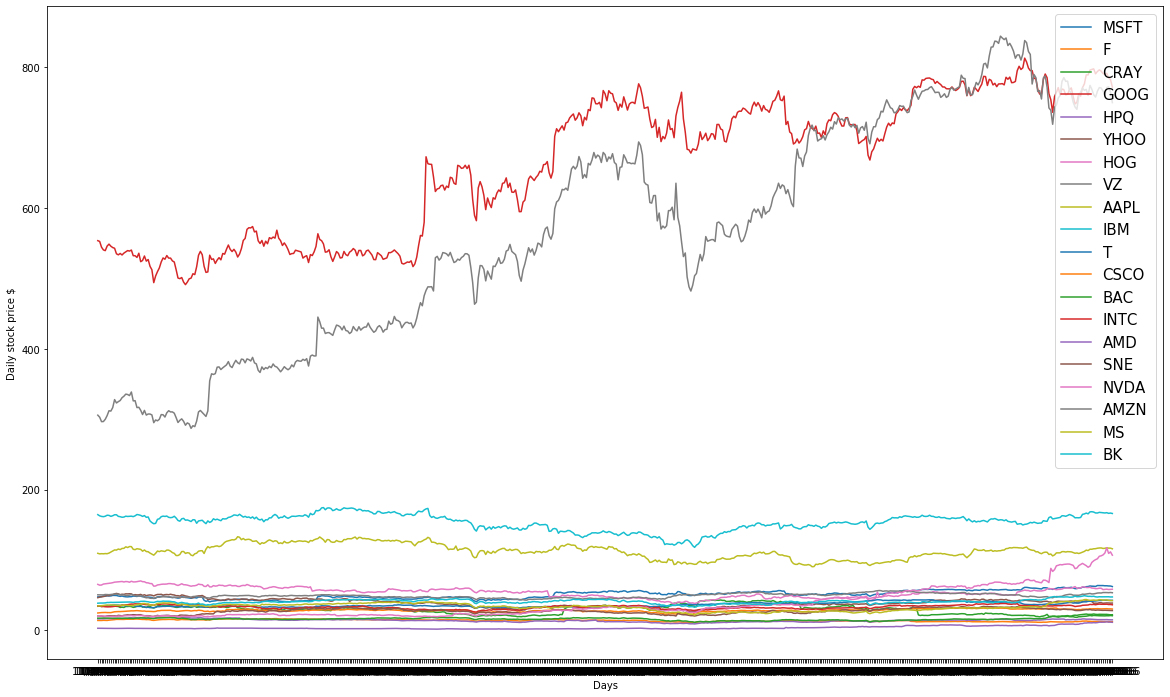

In [0]:
daily = df.set_index("Date")

plt.figure(figsize=(20,12))

for plot in daily.columns.values:
  plt.plot(daily.index, daily[plot], label=plot)
plt.legend(loc='best', fontsize=15)
plt.ylabel("Daily stock price $")
plt.xlabel("Days")
plt.show()

## Portfolio Value

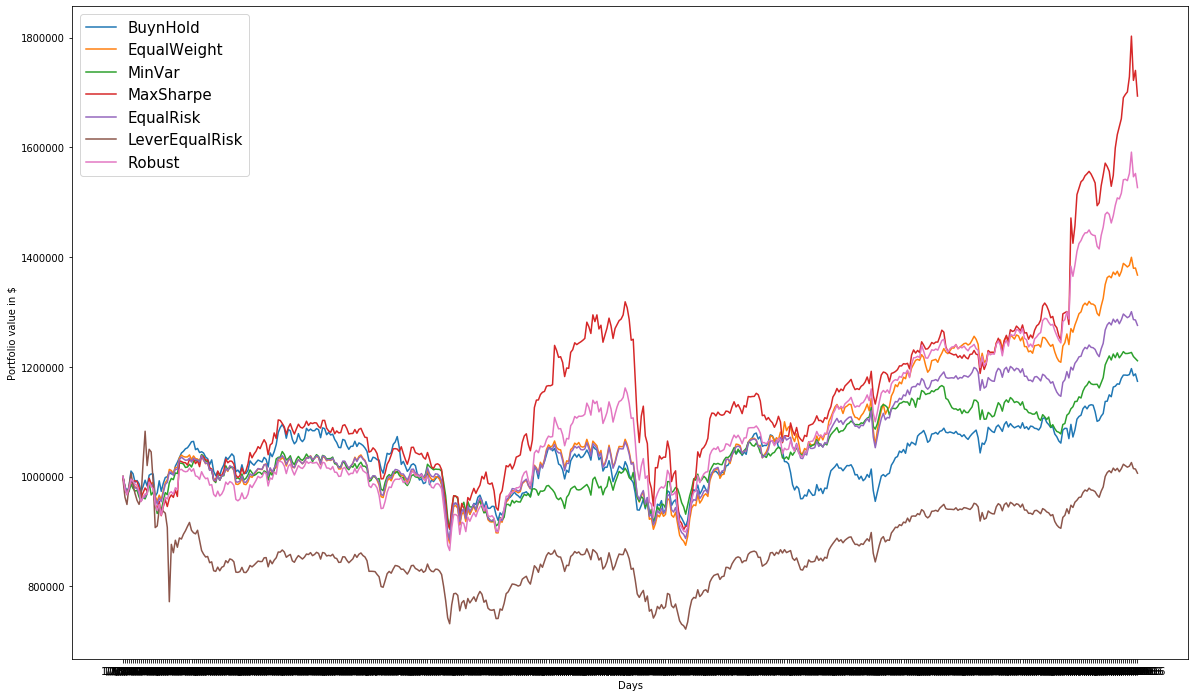

In [0]:
# Plot results

###################### Insert your code here ############################
portfolio_dataframe = pd.DataFrame(df["Date"])
portfolio_dataframe = portfolio_dataframe.iloc[41:] # Slice Period 0 (first 41 days from the dataframe)

# Append all values 
portfolio_dataframe["BuynHold"] = daily_values_buy_and_hold_flat
portfolio_dataframe["EqualWeight"] = daily_values_equal_weighted_flat
portfolio_dataframe["MinVar"] = daily_values_min_var_flat
portfolio_dataframe["MaxSharpe"] = daily_values_max_sharpe_flat
portfolio_dataframe["EqualRisk"] = daily_values_equal_risk_flat
portfolio_dataframe["LeverEqualRisk"] = daily_values_lever_equal_risk_flat
portfolio_dataframe["Robust"] = daily_values_robust_flat
portfolio_dataframe = portfolio_dataframe.set_index("Date")

fig = plt.figure(figsize=(20,12))

for plot in portfolio_dataframe.columns.values:
  plt.plot(portfolio_dataframe.index, portfolio_dataframe[plot], label=plot)
plt.legend(loc='upper left', fontsize=15)
plt.ylabel("Portfolio value in $")
plt.xlabel("Days")
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001791256A358>,
      dtype=object)

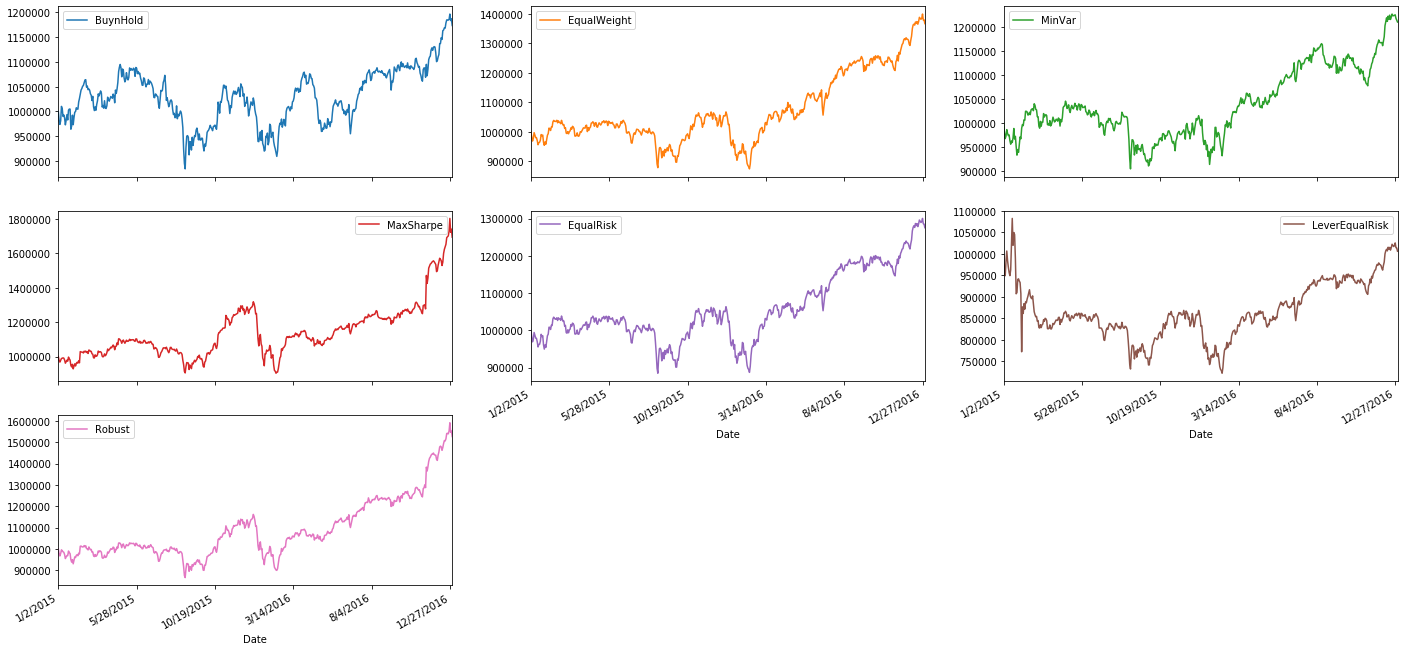

In [0]:
portfolio_dataframe.plot(subplots = True, layout = (4,3), figsize = (24,16))

## Fluctuation

### Daily Fluctuation

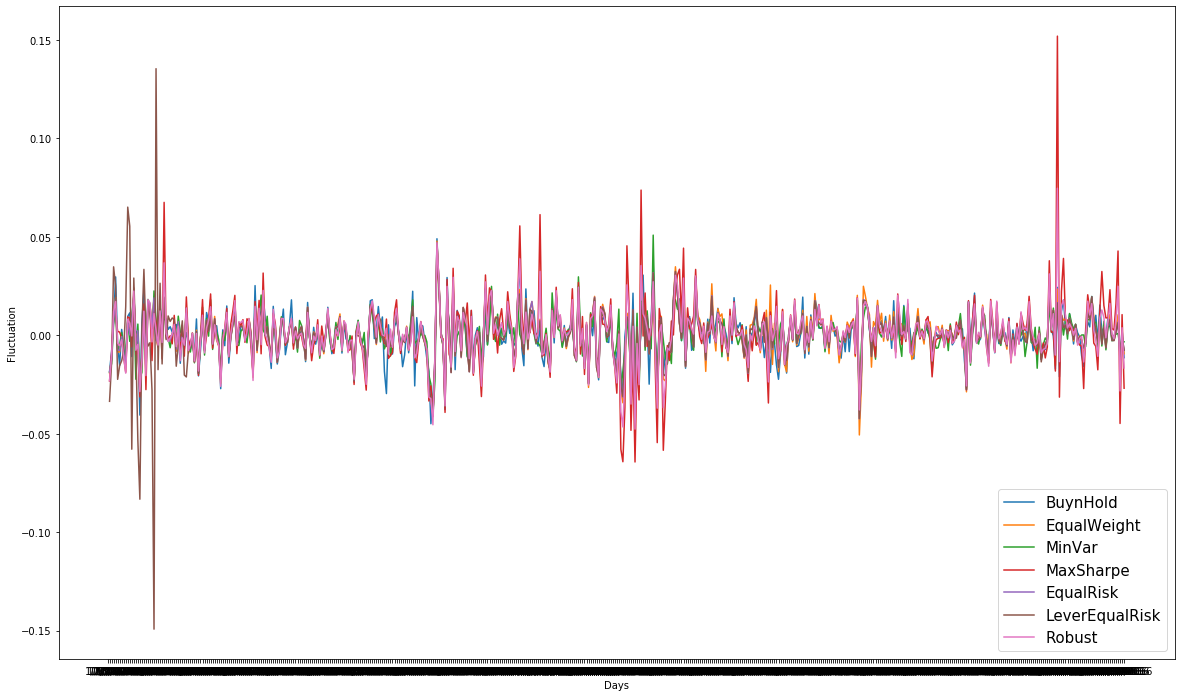

In [0]:
port_fluct = portfolio_dataframe.pct_change()

plt.figure(figsize=(20,12))

for plot in port_fluct.columns.values:
  plt.plot(port_fluct.index, port_fluct[plot], label=plot)
plt.legend(loc='best', fontsize=15)
plt.ylabel("Fluctuation")
plt.xlabel("Days")
plt.show()

### Periodical Fluctuation

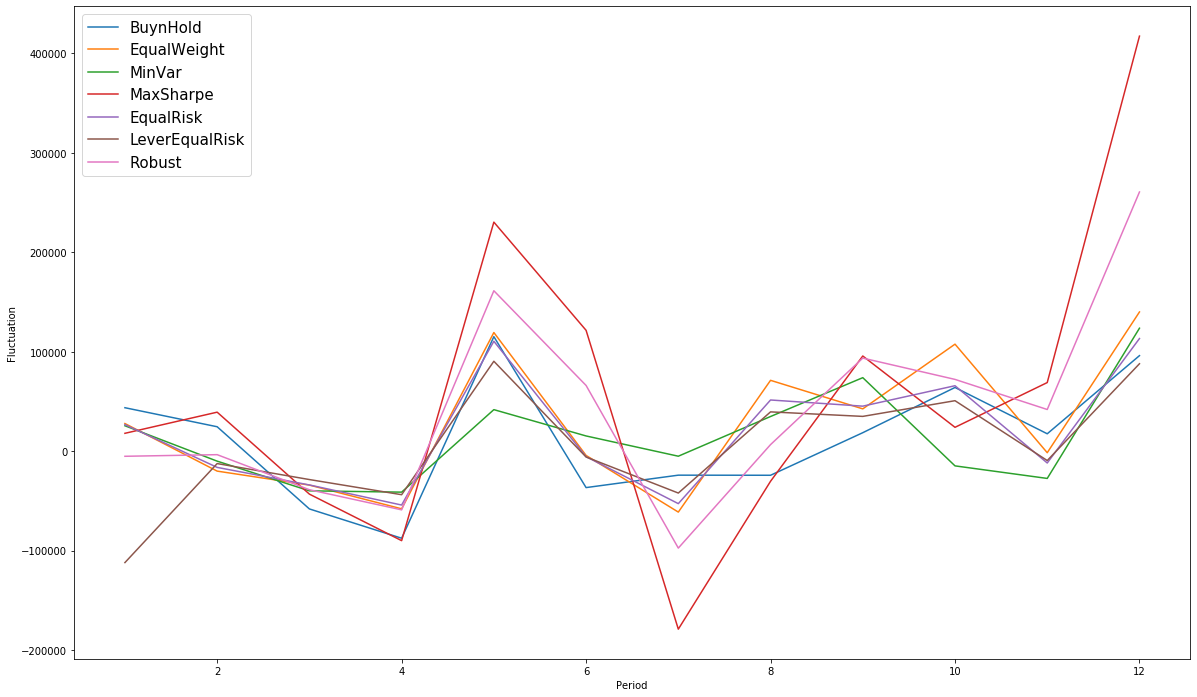

In [0]:
period_fluct = pd.DataFrame(np.diff(period_values_buy_and_hold), columns=["BuynHold"])

period_fluct["EqualWeight"] = np.diff(period_values_equal_weighted)
period_fluct["MinVar"] = np.diff(period_values_min_var)
period_fluct["MaxSharpe"] = np.diff(period_values_max_sharpe)
period_fluct["EqualRisk"] = np.diff(period_values_equal_risk)
period_fluct["LeverEqualRisk"] = np.diff(period_values_lever_equal_risk)
period_fluct["Robust"] = np.diff(period_values_robust)
period_fluct.index += 1

plt.figure(figsize=(20,12))

for plot in period_fluct.columns.values:
  plt.plot(period_fluct.index, period_fluct[plot], label=plot)
plt.legend(loc='best', fontsize=15)
plt.ylabel("Fluctuation")
plt.xlabel("Period")
plt.show()

## Portfolio Weights

### Portfoio Weight for Minimum Variance Strategy

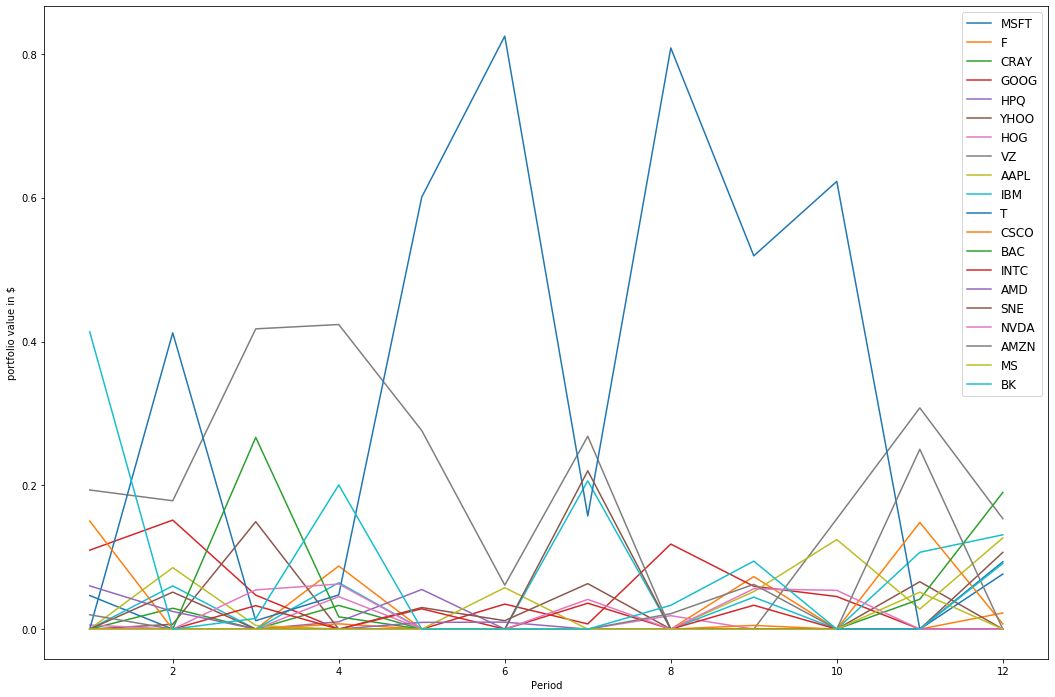

In [0]:
labels = list(df.columns.values)
labels = labels[1:]

portfolio_weights = pd.DataFrame(portfolio_weights_min_var, columns = labels)
portfolio_weights.index += 1

plt.figure(figsize=(18,12))

for plot in portfolio_weights.columns.values:
  plt.plot(portfolio_weights.index, portfolio_weights[plot], label=plot)
plt.legend(loc='best', fontsize=12)
plt.ylabel('portfolio value in $')
plt.xlabel("Period")
plt.show()

### Portfolio Weight for Maximum Sharpe Ratio Strategy

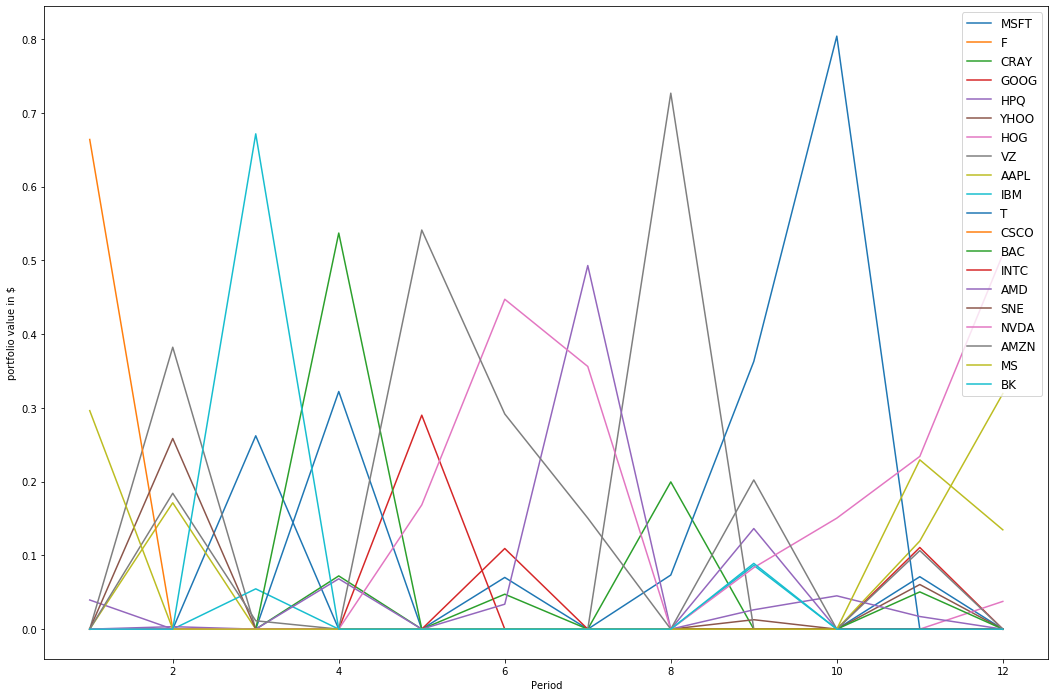

In [0]:
portfolio_weights = pd.DataFrame(portfolio_weights_max_sharpe, columns = labels)
portfolio_weights.index += 1

plt.figure(figsize=(18,12))

for plot in portfolio_weights.columns.values:
  plt.plot(portfolio_weights.index, portfolio_weights[plot], label=plot)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('portfolio value in $')
plt.xlabel("Period")
plt.show()

### Portfolio Weight for Robust Strategy

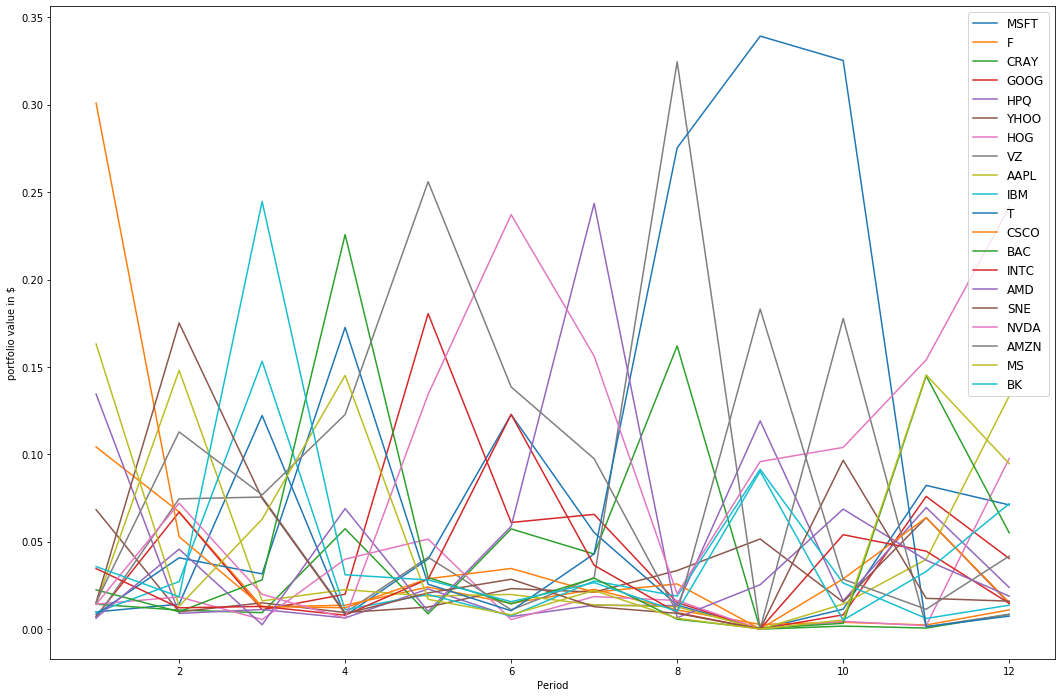

In [0]:
portfolio_weights = pd.DataFrame(portfolio_weights_robust, columns = labels)
portfolio_weights.index += 1

plt.figure(figsize=(18,12))

for plot in portfolio_weights.columns.values:
  plt.plot(portfolio_weights.index, portfolio_weights[plot], label=plot)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('portfolio value in $')
plt.xlabel("Period")
plt.show()

## Cash Value at end of each period

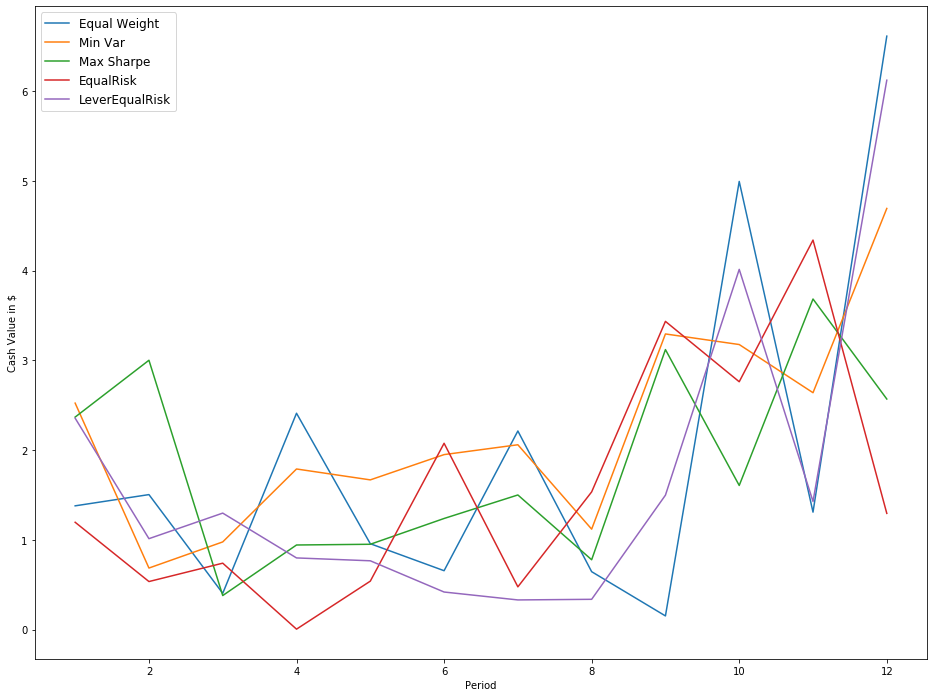

In [0]:
portfolio_cash = pd.DataFrame(cash_equal_weight,columns = ["Equal Weight"])
portfolio_cash.index += 1
portfolio_cash["Min Var"] = cash_min_var
portfolio_cash["Max Sharpe"] = cash_max_sharpe
portfolio_cash["EqualRisk"] = cash_equal_risk
portfolio_cash["LeverEqualRisk"] = cash_lever_equal_risk
period_fluct["Robust"] = np.diff(period_values_robust)

plt.figure(figsize=(16,12))

for plot in portfolio_cash.columns.values:
  plt.plot(portfolio_cash.index, portfolio_cash[plot], label=plot)
plt.legend(loc='best', fontsize=12)
plt.ylabel('Cash Value in $')
plt.xlabel("Period")
plt.show()